KKN: 48/102 correctly predicted.
SVC: 57/102 correctly predicted.
Randomd Forest Classifier: 84/102 correctly predicted.
Naive Bayes: 81/102 correctly predicted.


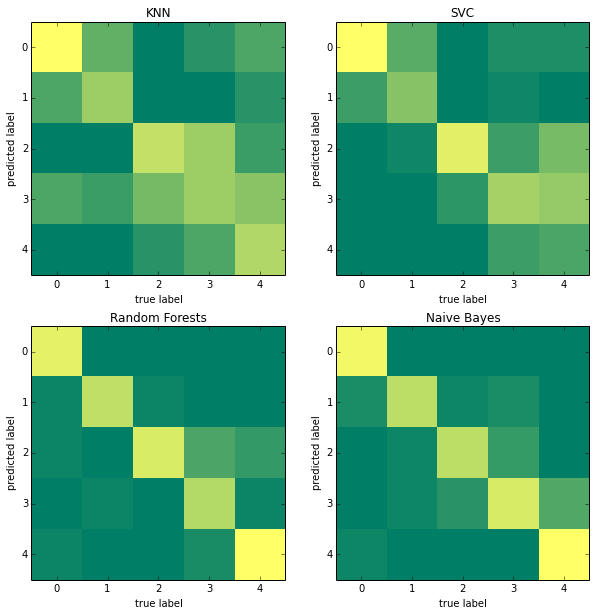

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time

###DATA MANIPULATION

#Load data
X = np.load('AccData/X.npy')
y = np.load('AccData/A.npy')

#Remove outliers
X = np.delete(X, [0,150], axis=0)
y = np.delete(y, [0,150], axis=0)
    
#Basic statistics
from scipy import stats

X_rms = np.sqrt(np.average(X**2, axis=1)) #root mean square value of x, y, and z

X_mean = np.mean(X_rms,axis=1) #mean of X_rms (in time)
X_var = np.var(X_rms, axis=1) #variance of X_rms (in time)
X_skew = stats.skew(X_rms, axis=1) #skewnes of distribution
X_kurt = stats.kurtosis(X_rms, axis=1)

#Calculate body tilt
tilt = np.arccos(X[:,2,:]/np.sqrt(X[:,0,:]**2+X[:,1,:]**2+X[:,2,:]**2))

tilt_mean = np.mean(tilt,axis=1)
tilt_var = np.var(tilt,axis=1)
tilt_skew = stats.skew(tilt, axis=1)
tilt_kurt = stats.kurtosis(tilt, axis=1)

#MACHINE LEARNING

#Feature Matrix
#features = X_mean, X_var, X_skew, X_kurt, tilt_mean, tilt_var, tilt_skew, tilt_kurt
features = X_var, X_kurt, tilt_mean, tilt_var, tilt_skew
F = np.column_stack(features)

#Split into test and training set
from sklearn.cross_validation import train_test_split

F_train, F_test, y_train, y_test = train_test_split(F, y, test_size=0.25, random_state=42)

#KNN model
from sklearn import neighbors
y_pred_1 = neighbors.KNeighborsClassifier(n_neighbors=1).fit(F_train, y_train).predict(F_test)

#SVC model
from sklearn.svm import SVC
y_pred_2 = SVC(kernel='linear').fit(F_train, y_train).predict(F_test)

#Random Forest Classifier
#from sklearn.ensemble import RandomForestClassifier
#y_pred_3 = RandomForestClassifier(n_estimators=20, random_state=0).fit(F_train, y_train).predict(F_test)

#Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
model_3 = ExtraTreesClassifier(n_estimators=20, random_state=0)
y_pred_3 = model_3.fit(F_train, y_train).predict(F_test)
imp = model_3.feature_importances_

#plt.bar(range(len(imp)),imp, align='center', alpha=0.4)

#from sklearn.ensemble import AdaBoostClassifier
#y_pred_4 = AdaBoostClassifier().fit(F_train, y_train).predict(F_test)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB
y_pred_4 = GaussianNB().fit(F_train, y_train).predict(F_test)

#ASSESING HOW WELL MACHINE LEARNING DID

print("KKN: %d/%d correctly predicted." % (((y_test == y_pred_1).sum()),len(y_test)))
print("SVC: %d/%d correctly predicted." % (((y_test == y_pred_2).sum()),len(y_test)))
print("Randomd Forest Classifier: %d/%d correctly predicted." % (((y_test == y_pred_3).sum()),len(y_test)))
print("Naive Bayes: %d/%d correctly predicted." % (((y_test == y_pred_4).sum()),len(y_test)))

#Confusion matrix
from sklearn import metrics

confu_matrix_1 = metrics.confusion_matrix(y_pred_1, y_test)
confu_matrix_2 = metrics.confusion_matrix(y_pred_2, y_test)
confu_matrix_3 = metrics.confusion_matrix(y_pred_3, y_test)
confu_matrix_4 = metrics.confusion_matrix(y_pred_4, y_test)

#plot the data in three dimensions
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0,0].imshow(confu_matrix_1, interpolation='nearest', cmap=plt.cm.summer)
ax[0,0].set_title("KNN")
ax[0,0].set_xlabel("true label")
ax[0,0].set_ylabel("predicted label")

ax[0,1].imshow(confu_matrix_2, interpolation='nearest', cmap=plt.cm.summer)
ax[0,1].set_title("SVC")
ax[0,1].set_xlabel("true label")
ax[0,1].set_ylabel("predicted label")

ax[1,0].imshow(confu_matrix_3, interpolation='nearest', cmap=plt.cm.summer)
ax[1,0].set_title("Random Forests")
ax[1,0].set_xlabel("true label")
ax[1,0].set_ylabel("predicted label")

ax[1,1].imshow(confu_matrix_4, interpolation='nearest', cmap=plt.cm.summer)
ax[1,1].set_title("Naive Bayes")
ax[1,1].set_xlabel("true label")
ax[1,1].set_ylabel("predicted label")

In [ ]:
#DTW
from mlpy import dtw_std

d_av = np.zeros((X.shape[0]),dtype=float)
for i in range(X.shape[0]):
    d_xy = dtw_std(X[i,0,:],X[i,1,:])
    d_xz = dtw_std(X[i,0,:],X[i,2,:])
    d_yz = dtw_std(X[i,1,:],X[i,2,:])
    d_av[i] = (d_xy+d_xz+d_yz)/3

#Longest common subsequence
from mlpy import lcs_real
lcs_av = np.zeros((X.shape[0]),dtype=float)
for i in range(X.shape[0]):
    lcs_xy,path = lcs_real(X[i,0,:],X[i,1,:],eps=.3,delta=15)
    lcs_xz,path = lcs_real(X[i,0,:],X[i,2,:],eps=.3,delta=15)
    lcs_yz,path = lcs_real(X[i,1,:],X[i,2,:],eps=.3,delta=15)
    lcs_av[i] = (lcs_xy+lcs_xz+lcs_yz)/3